In [1]:
#carry out ML to extract urban areas. 
#can then extend this back in time to get when urban change took place.

In [2]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
#import sys
#sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
import odc.algo

# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import datacube

import dask

CMAP = "Blues"

In [3]:
from __future__ import print_function, division
from osgeo import gdal, gdal_array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, cohen_kappa_score, mean_squared_error, classification_report
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image as ImageSave
from math import sqrt
import os
from IPython.display import Image

In [4]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

In [5]:
dc = datacube.Datacube(app = 'land_degredation')#, config = '/home/localuser/.datacube.conf')

from matplotlib.cm import RdYlGn, Greens
from odc.algo import to_f32, from_float, xr_geomedian
from datacube_utilities.dc_load import get_product_extents
from datacube_utilities.dc_time import dt_to_str
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
from datacube_utilities.dc_rgb import rgb
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.createindices import NDVI
from datacube_utilities.fromDCALscripts import threshold_plot
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.import_export import export_xarray_to_multiple_geotiffs


In [80]:
###Load in image
#inputs
#options "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4" and "SENTINEL_2"
platform_base = "SENTINEL_2"
#For Fiji this should be the only option - may change for Solomon and Vanuatu
output_projection = "EPSG:3460"
crs = "EPSG:3460"
res = (10)

# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

#set baseline start and end of period
baseline_start_date = '2019-1-1'
baseline_end_date = '2019-12-30'
#nadi
#aoi_wkt = "POLYGON((177.384445215936 -17.725841212511558,177.53619387316257 -17.725841212511558,177.53619387316257 -17.8278433805643,177.384445215936 -17.8278433805643,177.384445215936 -17.725841212511558))"

#suva
aoi_wkt = "POLYGON((178.39699689321165 -18.061332095979633,178.55080548696165 -18.061332095979633,178.55080548696165 -18.18467000208122,178.39699689321165 -18.18467000208122,178.39699689321165 -18.061332095979633))"

In [81]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [82]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

In [83]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)
print(lat_range)
print(lon_range)

(3868865.296636806, 3882539.0512192366)
(1962643.4711290102, 1978898.4636792026)


In [123]:
allmeasurements = ["green","red", "blue", "nir","swir1","swir2"]
#water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_geomedian_annual'
        measurements = allmeasurements
        ###CHANGE WHEN S2 WOFS READY
        #water_product = 'SENTINEL_2_PRODUCT DEFS'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements
        product = 'ls8_geomedian_annual'
        #water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements
        product = 'ls7_geomedian_annual'
        #water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product, measurements

In [124]:
baseline_product, measurement = create_product_measurement(platform_base)

In [125]:
#create resolution
resolution = (-res, res)

In [126]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [127]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_start_date, baseline_end_date)

In [128]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_range,
    'x': lon_range,
    'output_crs': output_projection,
    'measurements': measurement,
    'resolution': resolution,
    'dask_chunks': dask_chunks
}


In [129]:
baseline_ds = dc.load(
    time = baseline_time_period,
    product = baseline_product,
    platform = platform_base,
    crs = crs,
    **query
)


In [130]:
print(baseline_ds)

<xarray.Dataset>
Dimensions:  (time: 1, x: 1626, y: 1368)
Coordinates:
  * time     (time) datetime64[ns] 2019-07-02
  * y        (y) float64 3.883e+06 3.883e+06 3.883e+06 ... 3.869e+06 3.869e+06
  * x        (x) float64 1.963e+06 1.963e+06 1.963e+06 ... 1.979e+06 1.979e+06
Data variables:
    green    (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    red      (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue     (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir      (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir1    (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir2    (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:      EPSG:3460


In [131]:
img_ds = baseline_ds.compute()

Error opening source dataset: s3://public-eo-data/common_sensing/fiji/sentinel_2_geomedian/s2_geomedian_2019-01-01_2019-12-31_epsg3460_178.0_-18.5_178.5_-18.0_blue.tif


RasterioIOError: '/vsis3/public-eo-data/common_sensing/fiji/sentinel_2_geomedian/s2_geomedian_2019-01-01_2019-12-31_epsg3460_178.0_-18.5_178.5_-18.0_blue.tif' does not exist in the file system, and is not recognized as a supported dataset name.

In [132]:
T1_img = img_ds.isel(time = 0)

ValueError: dimensions {'time'} do not exist

In [ ]:
write_geotiff_from_xr('img_ds_S2.tiff', T1_img, crs=output_projection, x_coord = 'x', y_coord = 'y')

In [ ]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [ ]:
## vector to raster wtih same res as input raster

In [59]:
from osgeo import gdal
from osgeo import ogr
from osgeo import gdalconst

#dataset from which to base pixel size and extent for rasterization of training datasets
ndsm = 'img_ds.tiff'
#training data
shp = 'attempt105.geojson'
#openlayers
data = gdal.Open(ndsm, gdalconst.GA_ReadOnly)
geo_transform = data.GetGeoTransform()
#source_layer = data.GetLayer()
#get dimensions
x_min = geo_transform[0]
y_max = geo_transform[3]
x_max = x_min + geo_transform[1] * data.RasterXSize
y_min = y_max + geo_transform[5] * data.RasterYSize
x_res = data.RasterXSize
y_res = data.RasterYSize
mb_v = ogr.Open(shp)
mb_l = mb_v.GetLayer()
pixel_width = geo_transform[1]
#name for output of rasterized geotif
output = 'my2.tif'

target_ds = gdal.GetDriverByName('GTiff').Create(output, x_res, y_res, 1, gdal.GDT_Byte)
proj=data.GetProjection() #y
target_ds.SetProjection(proj)
#target_ds.SetGeoTransform((x_min, pixel_width, 0, y_min, 0, pixel_width))
geotrans=data.GetGeoTransform()  #get GeoTranform from existed 'data0'

band = target_ds.GetRasterBand(1)
NoData_value = -999999
band.SetNoDataValue(NoData_value)
band.FlushCache()
target_ds.SetGeoTransform(geotrans)
gdal.RasterizeLayer(target_ds, [1], mb_l, options=["ATTRIBUTE=Class"])


target_ds = None

In [60]:
#path to image
#path to training/test data
#roi_ds = gdal.Open('testoutput.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('my2.tif', gdal.GA_ReadOnly)
img_ds = gdal.Open('img_ds.tiff', gdal.GA_ReadOnly)

In [61]:
roi_dataset = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

In [62]:
print(roi_dataset.max())

5


roi = np.zeros((roi_ds.RasterYSize, roi_ds.RasterXSize, roi_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(roi_ds.GetRasterBand(1).DataType))
for b in range(roi.shape[2]):
    roi[:, :, b] = roi_ds.GetRasterBand(b + 1).ReadAsArray()
print(roi)

In [63]:
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
#print(img.dtype)
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    print(b)
print(img)

0
1
2
3
4
5
[[[-9999 -9999 -9999 -9999 -9999 -9999]
  [-9999 -9999 -9999 -9999 -9999 -9999]
  [-9999 -9999 -9999 -9999 -9999 -9999]
  ...
  [  488   853   754  3035  1903  1202]
  [  311   677   530  3648  1909   940]
  [  463   887   709  4000  2178  1252]]

 [[-9999 -9999 -9999 -9999 -9999 -9999]
  [-9999 -9999 -9999 -9999 -9999 -9999]
  [-9999 -9999 -9999 -9999 -9999 -9999]
  ...
  [  381   754   590  3772  1939  1047]
  [  254   660   406  4536  2074   942]
  [  387   782   611  3923  2062  1090]]

 [[-9999 -9999 -9999 -9999 -9999 -9999]
  [-9999 -9999 -9999 -9999 -9999 -9999]
  [-9999 -9999 -9999 -9999 -9999 -9999]
  ...
  [  248   718   443  4259  2068   951]
  [  254   762   497  4407  2253  1013]
  [  312   660   476  3876  1905   991]]

 ...

 [[  221   128    31    24    52    50]
  [  237   141    47    36    67    59]
  [  240   148    53    44    71    65]
  ...
  [  297   292    95    31    39    32]
  [  303   298    98    32    37    36]
  [  290   278    94    32    39

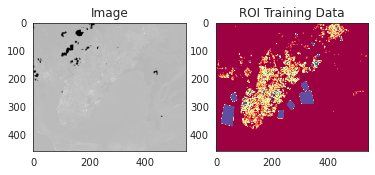

In [91]:
# Display the image and the Training/Test raster
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('Image')
plt.subplot(122)
plt.imshow(roi_dataset, cmap=plt.cm.Spectral, vmin=0, vmax=0.5)
plt.title('ROI Training Data')
plt.show()

In [92]:
labels = np.unique(roi_dataset[roi_dataset > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))

The training data include 5 classes: [1 2 3 4 5]


In [93]:
#set X and y as image and training/test data.
X = img[roi_dataset > 0, :]
y = roi_dataset[roi_dataset > 0 ]

In [94]:
#Split the data into training and testing, by 80:20 split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [95]:
unique, counts = np.unique(y_train, return_counts=True)
dict_ytrain = dict(zip(unique, counts))
unique2, counts2 = np.unique(y_test, return_counts=True)
dict_ytest = dict(zip(unique2,counts2))
print("counts")
print('Train counts', counts)
print('Test counts', counts2)


counts
Train counts [4706   71   61 4671   75]
Test counts [1177   18   15 1168   19]


In [96]:
# Initialize random forest model with 200 trees, and balanced class weight
rf = RandomForestClassifier(n_estimators=200, oob_score=True, class_weight="balanced", min_samples_leaf=100)
rf = rf.fit(X_train,y_train)

In [97]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 90.1085141903172%


In [98]:
# Setup a dataframe, for truth and predicted values of training data
df = pd.DataFrame()
df['truth'] = y_train
df['predict'] = rf.predict(X_train)
# Setup a dataframe, for truth and predicted values of test data
df2 = pd.DataFrame()
df2['truth'] = y_test
df2['predict'] = rf.predict(X_test)

In [99]:
# Cross-tabulate predictions
print(pd.crosstab(df2['truth'], df2['predict'], margins=True))

predict    1   2   3     4    5   All
truth                                
1        931  14  73     3  156  1177
2          0  18   0     0    0    18
3          1   0  13     0    1    15
4          0   0   0  1168    0  1168
5          1   2   2     0   14    19
All      933  34  88  1171  171  2397


In [100]:
#calculate kappa score
#print("this is kappa", cohen_kappa_score(df2['truth'], df2['predict'])) *100
kappaScore = cohen_kappa_score(df2['truth'], df2['predict'])
kSPer = kappaScore*100
print("this is kappa", kSPer) 
#print("this is kappa", cohen_kappa_score(df2['truth'], df2['predict']))


this is kappa 81.48022374921325


In [101]:
#calculate accuracy score
print('accuracy score', accuracy_score(df2['truth'], df2['predict']))
#print classification report
print(classification_report(df2['truth'], df2['predict']))

accuracy score 0.8944513975803087
              precision    recall  f1-score   support

           1       1.00      0.79      0.88      1177
           2       0.53      1.00      0.69        18
           3       0.15      0.87      0.25        15
           4       1.00      1.00      1.00      1168
           5       0.08      0.74      0.15        19

    accuracy                           0.89      2397
   macro avg       0.55      0.88      0.59      2397
weighted avg       0.98      0.89      0.93      2397



In [102]:
#This function prints and plots the confusion matrix.
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.Blues, annot=True, annot_kws={"size": 3}):
    # Compute confusion matrix
    cm = confusion_matrix(df2['truth'], df2['predict'])
    # Only use the labels that appear in the data
    #classes = ('Built-up', 'Forest', 'Water', 'Grass', 'WB', 'WW', 'OSR')
    classes = ('Built-up', 'Forest', 'Grass', 'Water', 'Bare Soil')
    print("diagonal", cm.diagonal()/cm.sum(axis=1))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    VALUE_SIZE = 10
    LABEL_SIZE = 12

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    #show tick labels and label them with list enteries.
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize = LABEL_SIZE)
    plt.setp(ax.get_yticklabels(), fontsize = LABEL_SIZE)
    #path for output of normalised and non-normalised confusion matrices
    notn = 'cm.png'
    norm = 'ncm.png'

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center", fontsize=VALUE_SIZE,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #save the outputs on the confusion matrices
    if normalize:
        plt.savefig(norm)
        print("saved to", norm)
    else:
        plt.savefig(notn)
        print("saved to", notn)
    return ax


diagonal [0.79 1.   0.87 1.   0.74]
Confusion matrix, without normalization
[[ 931   14   73    3  156]
 [   0   18    0    0    0]
 [   1    0   13    0    1]
 [   0    0    0 1168    0]
 [   1    2    2    0   14]]
saved to cm.png
diagonal [0.79 1.   0.87 1.   0.74]
Normalized confusion matrix
[[0.79 0.01 0.06 0.   0.13]
 [0.   1.   0.   0.   0.  ]
 [0.07 0.   0.87 0.   0.07]
 [0.   0.   0.   1.   0.  ]
 [0.05 0.11 0.11 0.   0.74]]
saved to ncm.png


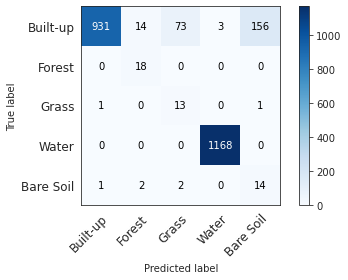

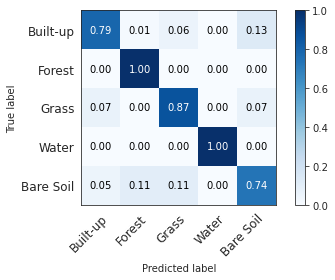

In [103]:
#class labels
classes = ('Built-up', 'Forest', 'Grass', 'Water', 'Bare Soil')

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(df2['truth'], df2['predict'], classes=classes)

# Plot normalized confusion matrix
plot_confusion_matrix(df2['truth'], df2['predict'], classes=classes, normalize=True)
plt.show()



In [104]:
# Use full image, reshape to 2darray for classification (nrow * ncol, nband)
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :].reshape(new_shape)

In [105]:
# Now predict each pixel in the image.
class_prediction = rf.predict(img_as_array)

In [106]:
# Reshape classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
print(np.unique(class_prediction))
#im = ImageSave.fromarray(class_prediction)
#im.save('map.tif')

[1 2 3 4 5]


In [107]:
print(class_prediction.shape)
xsize = class_prediction.shape[0]
ysize = class_prediction.shape[1]
print(xsize)

(456, 543)
456


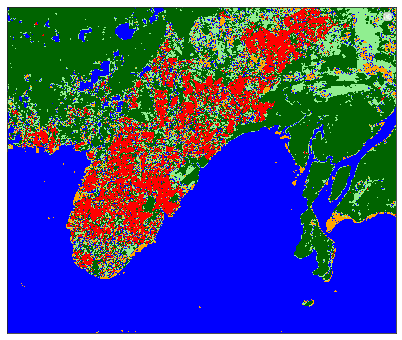

In [108]:
# use seaborne raster plots
sns.set_style("white")
#set colours for each class
colors = ['red', 'darkgreen', 'lightgreen', 'blue', 'orange']
cmap = ListedColormap(colors)
# Plot newly classified and masked raster
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(class_prediction, cmap = cmap)
ax.set_yticks([])
ax.set_xticks([])
ax.legend(np.unique(class_prediction))
plt.show()

In [109]:
dst_filename = 'xxx.tiff'
x_pixels = ysize  # number of pixels in x
y_pixels = xsize  # number of pixels in y
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(dst_filename,x_pixels, y_pixels, 1,gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(class_prediction)

# follow code is adding GeoTranform and Projection
geotrans=img_ds.GetGeoTransform()  #get GeoTranform from existed 'data0'
proj=img_ds.GetProjection() #you can get from a exsited tif or import 
dataset.SetGeoTransform(geotrans)
dataset.SetProjection(proj)
dataset.FlushCache()
dataset=None

## Test on new area

In [110]:
img_ds2 = gdal.Open('img_ds2.tiff', gdal.GA_ReadOnly)

In [111]:
img2 = np.zeros((img_ds2.RasterYSize, img_ds2.RasterXSize, img_ds2.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds2.GetRasterBand(1).DataType))
#print(img.dtype)
for b in range(img2.shape[2]):
    img2[:, :, b] = img_ds2.GetRasterBand(b + 1).ReadAsArray()
    print(b)
print(img2)

0
1
2
3
4
5
[[[ 270  216   64   36   28   22]
  [ 273  220   67   37   29   24]
  [ 276  221   70   39   31   25]
  ...
  [ 213  501  400 3160 1844  930]
  [ 300  622  542 3226 2022 1052]
  [ 384  715  683 3059 1942 1062]]

 [[ 262  214   63   36   27   20]
  [ 265  213   64   35   27   21]
  [ 270  218   67   34   30   23]
  ...
  [ 252  586  400 3715 2056  981]
  [ 275  597  410 3756 2102 1000]
  [ 266  587  400 3753 2049  971]]

 [[ 263  216   62   32   27   19]
  [ 265  217   64   33   29   20]
  [ 266  218   61   32   31   21]
  ...
  [ 262  519  408 3148 1932  954]
  [ 281  544  391 3375 1955  931]
  [ 281  566  410 3409 1959  941]]

 ...

 [[ 222  452  351 2005  979  502]
  [ 251  556  404 3113 1529  707]
  [ 299  623  502 3021 1728  836]
  ...
  [ 151  337  183 3740 1452  532]
  [ 131  323  172 3144 1223  457]
  [ 148  331  195 2604 1024  404]]

 [[ 251  501  417 2018 1121  589]
  [ 297  622  487 3132 1694  795]
  [ 362  722  638 3206 1959 1021]
  ...
  [ 154  352  198 3739 148

In [112]:
# Use full image, reshape to 2darray for classification (nrow * ncol, nband)
new_shape2 = (img2.shape[0] * img2.shape[1], img2.shape[2])
img_as_array2 = img2[:, :, :].reshape(new_shape2)

In [ ]:
# Now predict each pixel in the image.
class_prediction2 = rf.predict(img_as_array2)

In [ ]:
# Reshape classification map
class_prediction2 = class_prediction2.reshape(img2[:, :, 0].shape)
print(np.unique(class_prediction2))
#im = ImageSave.fromarray(class_prediction)
#im.save('map.tif')

In [ ]:
print(class_prediction2.shape)
xsize2 = class_prediction2.shape[0]
ysize2 = class_prediction2.shape[1]
print(xsize2)

In [ ]:
# use seaborne raster plots
sns.set_style("white")
#set colours for each class
colors = ['red', 'darkgreen', 'lightgreen', 'blue', 'orange']
cmap = ListedColormap(colors)
# Plot newly classified and masked raster
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(class_prediction2, cmap = cmap)
ax.set_yticks([])
ax.set_xticks([])
ax.legend(np.unique(class_prediction2))
plt.show()

In [ ]:
dst_filename = 'xxx2.tiff'
x_pixels = ysize  # number of pixels in x
y_pixels = xsize  # number of pixels in y
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(dst_filename,x_pixels, y_pixels, 1,gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(class_prediction2)

# follow code is adding GeoTranform and Projection
geotrans=img_ds2.GetGeoTransform()  #get GeoTranform from existed 'data0'
proj=img_ds2.GetProjection() #you can get from a exsited tif or import 
dataset.SetGeoTransform(geotrans)
dataset.SetProjection(proj)
dataset.FlushCache()
dataset=None